In this post we would try to show how one could infer the sparse representation of an image knowing an appropriate generative model for its synthesis. In particular, we will implement a convolutional version of the iterative shrinkage thresholding algorithm (ISTA) and its fast version, the FISTA. For computational efficiency, all these convolutions will be implemented by a [Fast Fourier Tansform](https://en.wikipedia.org/wiki/Fast_Fourier_transform). We will benchmark this on a realistic image size of $1024 \times 1024$ giving some timing results on a standard laptop.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
#%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
#from IPython.display import display, HTML
#def show_video(filename): 
#    return HTML(data='<video src="{}" loop autoplay width="600" height="600"></video>'.format(filename))
%load_ext autoreload
%autoreload 2

# problem statement: sparse events in a static image

In the first case that we will study, images are produced by the combination of a single kernal with sparse events. Think of it like some brushstrokes on a canvas, somes drops of rain that fell on the surface of a pond... 

For simplicity, the combination of these events will be considered linear. This is mostly true for instance in watercolor or in combining transparent surfaces and by ignoring saturation of the sensor for instance. To handle linearity, we will use linear algebra and matrices:  We will denote as $x$ the (raveled) image and these "events" as $y$. The kernels that define the brushstrokes is denoted as $A$ and will be explicited below. Generally, in matrix form, the genrativve model of the image is written:

$$
x = A y
$$

First, coefficients are drawn from a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) and sparse events are generated by using the . These will be convolved with a kernel defined using the ``MotionClouds``library. Let's first illustrate that for a small image size:

In [2]:
N_X, N_Y = 2**10, 2**10
N_X, N_Y = 2**7, 2**7
N_X, N_Y = 2**8, 2**8

rho = 1.e-2
seed = 42
rng = np.random.RandomState(seed)
sf_0 = .025
B_sf = .025
y_lambda = 1.61803

In [3]:
events = y_lambda * rng.laplace(size=(N_X, N_Y))

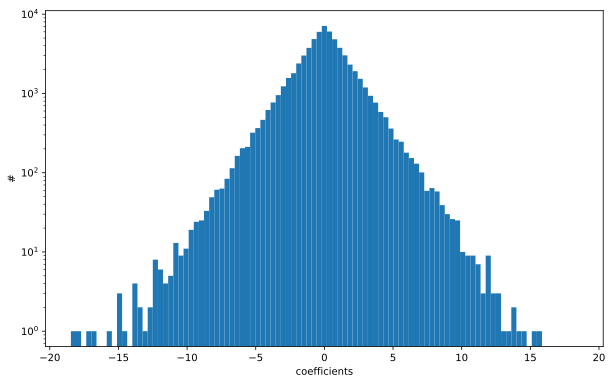

In [4]:
events_max = np.max(np.abs(events))
fig, ax = plt.subplots(figsize=figsize)
ax.hist(events.ravel(), bins=np.linspace(-events_max, events_max, 100, endpoint=True))
ax.set_xlabel('coefficients')
ax.set_yscale('log')
ax.set_ylabel('#');

In [5]:
print('mean, std=', events.mean(), events.std())

mean, std= -0.0030762160361596726 2.283752278229822


From this continuous distribution of coefficients, we will zero out to achieve a desired sparsity (in the $\ell_0$ pseudoi-norm sense):

In [6]:
threshold = np.quantile(np.absolute(events).ravel(), 1-rho)
print('threshold=', threshold)

threshold= 7.421234267082971


In [7]:
events_thr = events  * ((events < -threshold) + (events > threshold))

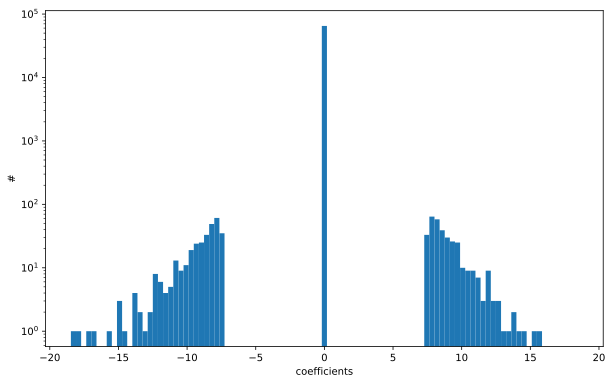

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(events_thr.ravel(), bins=np.linspace(-events_max, events_max, 100, endpoint=True))
ax.set_xlabel('coefficients')
ax.set_yscale('log')
ax.set_ylabel('#');

In [9]:
print('mean, std=', events_thr.mean(), events_thr.std())

mean, std= 0.0011076765546336421 0.922463001333858


TODO: use https://en.wikipedia.org/wiki/Shot_noise

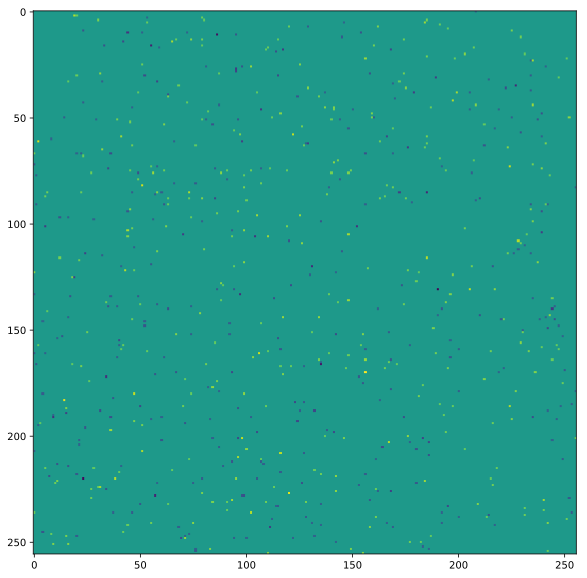

In [10]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(events_thr, cmap=plt.viridis());

Let's now generate the image by convolving it with an isotropic kernel, as definedd in the https://github.com/NeuralEnsemble/MotionClouds library:

In [11]:
import MotionClouds as mc
fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
opts = dict(V_X=0., V_Y=0., B_V=0, B_theta=np.inf, sf_0=sf_0, B_sf=B_sf)
envelope = mc.envelope_gabor(fx, fy, ft, **opts).squeeze()

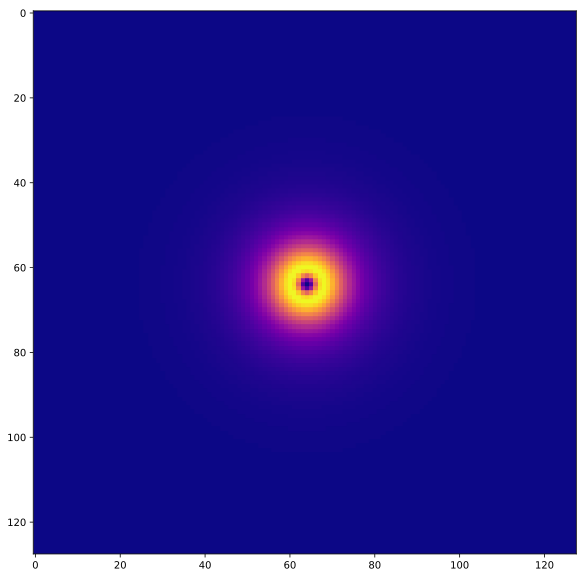

In [12]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
#ax.imshow(env.squeeze(), cmap=plt.plasma());
ax.imshow(envelope[(N_X//2-N_X//4):(N_X//2+N_X//4), (N_Y//2-N_Y//4):(N_Y//2+N_Y//4)], cmap=plt.plasma()); 

(This shape reminds me something... DOOH!)

Then we use the [Fourier transform](https://www.encyclopediaofmath.org/index.php/Fourier_transform) to actually perform the convolution (as implemented in the [Motion Clouds](https://github.com/NeuralEnsemble/MotionClouds) library):

In [13]:
x = mc.random_cloud(envelope[:, :, None], events=events_thr[:, :, None])
x = x.reshape((N_X, N_Y))
print('x.shape=', x.shape)

x.shape= (256, 256)


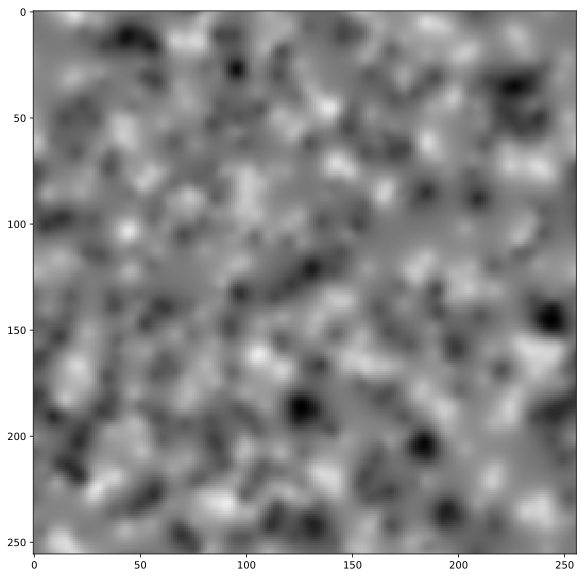

In [14]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
vmax = np.absolute(x).max()
ax.imshow(x, cmap=plt.gray(), vmin=-vmax, vmax=vmax);

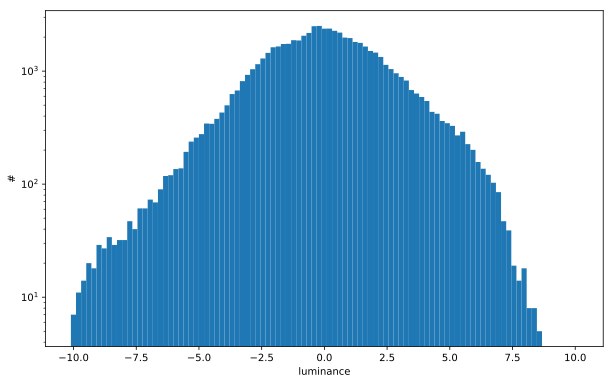

In [15]:
x_max = np.max(np.abs(x))
fig, ax = plt.subplots(figsize=figsize)
ax.hist(x.ravel(), bins=np.linspace(-x_max, x_max, 100, endpoint=True))
ax.set_xlabel('luminance')
ax.set_yscale('log')
ax.set_ylabel('#');

All in one function:

In [16]:
def MC_env(N_X, N_Y, opts=dict(V_X=0., V_Y=0., B_V=0, B_theta=np.inf, sf_0=sf_0, B_sf=B_sf)):
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)
    return mc.envelope_gabor(fx, fy, ft, **opts).squeeze()
envelope = MC_env(N_X, N_Y)

In [17]:
%%timeit
envelope = MC_env(N_X, N_Y)

14.3 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
def random_cloud(envelope, events):
    (N_X, N_Y) = envelope.shape
    #fx, fy, ft = mc.get_grids(N_X, N_Y, N_frame)    
    F_events = np.fft.fftn(events)
    F_events = np.fft.fftshift(F_events)
    
    Fz = F_events * envelope
    # de-centering the spectrum
    Fz = np.fft.ifftshift(Fz)
    #Fz[0, 0, 0] = 0. # removing the DC component
    z = np.fft.ifftn(Fz).real
    return z

In [19]:
%%timeit
random_cloud(envelope, events_thr)

27.2 ms ± 6.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
def model(envelope, events, verbose=False):
    if verbose: print('envelope.shape = ', envelope.shape)
    if verbose: print('events.shape = ', events.shape)
    N_X, N_Y = envelope.shape
    x = random_cloud(envelope, events=events)
    #x = x.reshape((N_X, N_Y))
    if verbose: print('x.shape=', x.shape)
    return x
x = model(envelope, events_thr, verbose=True)

envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


In [21]:
%%timeit
model(envelope, events_thr)

The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
8.91 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Merging both functions:

In [22]:
def model(envelope, events, verbose=False):
    if verbose: print('envelope.shape = ', envelope.shape)
    if verbose: print('events.shape = ', events.shape)
    N_X, N_Y = envelope.shape
    F_events = np.fft.fftn(events)
    F_events = np.fft.fftshift(F_events)
    Fz = F_events * envelope
    Fz = np.fft.ifftshift(Fz)
    x = np.fft.ifftn(Fz).real
    if verbose: print('x.shape=', x.shape)
    return x
x = model(envelope, events_thr, verbose=True)

envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


In [23]:
%%timeit
model(envelope, events_thr)

5.59 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
def generative_model(envelope, rho=rho, y_lambda=y_lambda, seed=seed, verbose=False):
    N_X, N_Y = envelope.shape
    if verbose: print('N_X, N_Y = ', envelope.shape)
    rng = np.random.RandomState(seed)
    events = y_lambda * rng.laplace(size=(N_X, N_Y))

    threshold = np.quantile(np.absolute(events).ravel(), 1.-rho)
    events = events  * ((events < -threshold) + (events > threshold))

    x = model(envelope, events, verbose=verbose)
    return events, x
events, x = generative_model(envelope, verbose=True)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


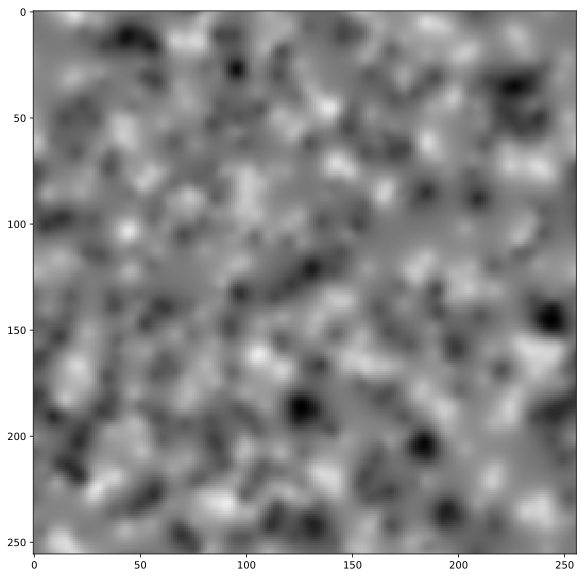

In [25]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
vmax = np.absolute(x).max()
ax.imshow(x, cmap=plt.gray(), vmin=-vmax, vmax=vmax);

In [26]:
envelope = MC_env(N_X, N_Y)

In [27]:
%%timeit
events, x = generative_model(envelope)

8.74 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, how do I retrieve the events knowing ``x``? This is a form of deconvolution:

## Deconvolution in the noiseless case: invertibility of the image to retrieve events

It's relatively easy to use the shape of the enveloppe to retrieve the events:

In [28]:
def invert(x, envelope, eps=1.e-16):
    Fx = np.fft.fft2(x)
    Fx = np.fft.fftshift(Fx)
    F_deconv = envelope * (1.-1.*(envelope==0)) / (envelope**2 + eps*(envelope==0))
    # applying the filter
    F_events = Fx*F_deconv
    # de-centering the spectrum
    F_events = np.fft.ifftshift(F_events)
    events = np.fft.ifft2(F_events).real 
    return events

envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)

events_pred = invert(x, envelope)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


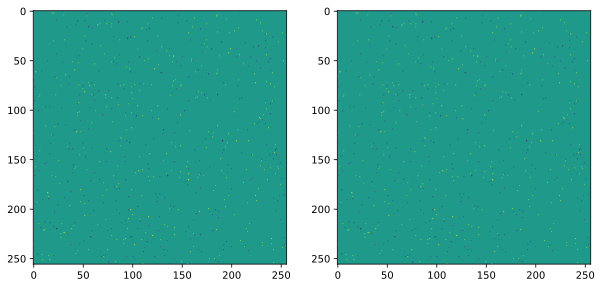

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width))
axs[0].imshow(events, cmap=plt.viridis())
axs[1].imshow(events_pred, cmap=plt.viridis());

Some statistics to show the efficiency of this method:

In [30]:
#print('enveloppe energy=', np.sqrt(((envelope)**2).mean()) )
def SE_y(events, events_pred):
    return ((events-events_pred)**2).sum()/(events**2).sum()
print('relative Squared error=', SE_y(events, events_pred))
def L1_y(events, events_pred):
    return np.abs(events-events_pred).sum()/np.abs(events).sum()
print('relative L1 error=', L1_y(events, events_pred))
#print('energy rec=', ((events_pred)**2).sum())
#print('energy input=', ((events.squeeze())**2).sum())
#print('ratio energy=', ((events_pred)**2).sum()/(events**2).sum())
#print('Squared ratio energy=', np.sqrt((events**2).sum()/(events_pred**2).sum()))

relative Squared error= 1.4418742572163661e-06
relative L1 error= 0.012203543362780884


In [31]:
def SE_x(x, envelope, events_pred):
    return ((x-model(envelope, events_pred))**2).sum()/(x**2).sum()
print('relative Squared image error=', SE_x(x, envelope, events_pred))

relative Squared image error= 1.7180332503534622e-31


Reconstruction is perfect up to the machine's numerical precision. This is true because the problem is invertible in that instance and that the ``invert`` function implements a generalization of the pseudo-inverse $A^+ = (A^T A )^{-1} A$ of the linear transform $x = A y$ generalized to the convolutional case defined in the ``model`` function.

TODO: give a short proof using the fact that ``A`` is a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix)

This method is fast:

In [32]:
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope)

In [33]:
%%timeit
events_pred = invert(x, envelope)

The slowest run took 5.15 times longer than the fastest. This could mean that an intermediate result is being cached.
11.8 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


And can be further accelerated using a pre-shifted filter:

In [34]:
def invert_f(x, envelope, eps=1.e-16):
    Fx = np.fft.fft2(x)
    F_deconv = envelope * (1.-1.*(envelope==0)) / (envelope**2 + eps*(envelope==0))
    # applying the filter
    F_events = Fx*F_deconv
    events = np.fft.ifft2(F_events).real 
    return events

envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope)

envelope_f = np.fft.fftshift(envelope)
events_pred = invert_f(x, envelope_f)
print('relative L1 error=', L1_y(events, events_pred))
print('relative Squared error=', SE_y(events, events_pred))

relative L1 error= 0.012203543362780884
relative Squared error= 1.4418742572163661e-06


In [35]:
print('relative Squared image error=', SE_x(x, envelope, events_pred))

relative Squared image error= 1.7180332503534622e-31


In [36]:
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope)
envelope = np.fft.fftshift(envelope)

In [37]:
%%timeit
events_pred = invert_f(x, envelope)

The slowest run took 4.00 times longer than the fastest. This could mean that an intermediate result is being cached.
16.5 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Instead of using the standard ``fft`` as in

In [38]:
%timeit np.fft.fft2(x)

2.13 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


... one could use the knowledge that the input signal is real:

In [39]:
%timeit np.fft.rfft2(x)

3.12 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Specifically, it is necessary to reshape the enveloppe in frequency space, see https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html :

In [40]:
np.fft.rfft2(x).shape

(256, 129)

such that finally:

In [41]:
def invert_r(x, envelope, eps=1.e-16):
    envelope = np.fft.fftshift(envelope)[:, :(envelope.shape[1]//2+1)]
    Fx = np.fft.rfft2(x)
    F_deconv = envelope * (1.-1.*(envelope==0)) / (envelope**2 + eps*(envelope==0))
    # applying the filter
    F_events = Fx*F_deconv
    events = np.fft.irfft2(F_events).real 
    return events

#mc.N_X, mc.N_Y = 2**7, 2**7
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)

events_pred = invert_r(x, envelope)
print('relative L1 error=', L1_y(events, events_pred))
print('relative Squared error=', SE_y(events, events_pred))
print('relative Squared image error=', SE_x(x, envelope, events_pred))

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)
relative L1 error= 0.012203543362780884
relative Squared error= 1.4418742572163655e-06
relative Squared image error= 2.0963404688160333e-31


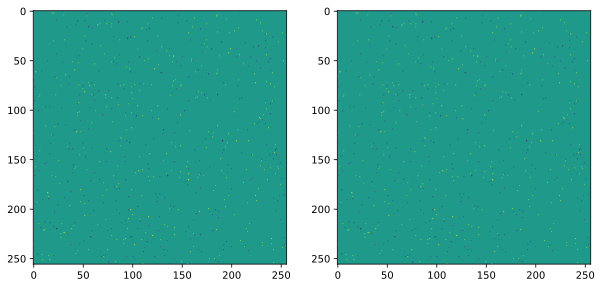

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width))
axs[0].imshow(events, cmap=plt.viridis())
axs[1].imshow(events_pred, cmap=plt.viridis());

In [43]:
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


In [44]:
%%timeit
events_pred = invert_r(x, envelope)

4.24 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Deconvolution in the noisy case (white noise): (partial) failure to retrieve sparse coefficients



In [45]:
noise = .05 # relative level of noise

In [46]:
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)
x_noise = x + noise * rng.normal(size=x.shape)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


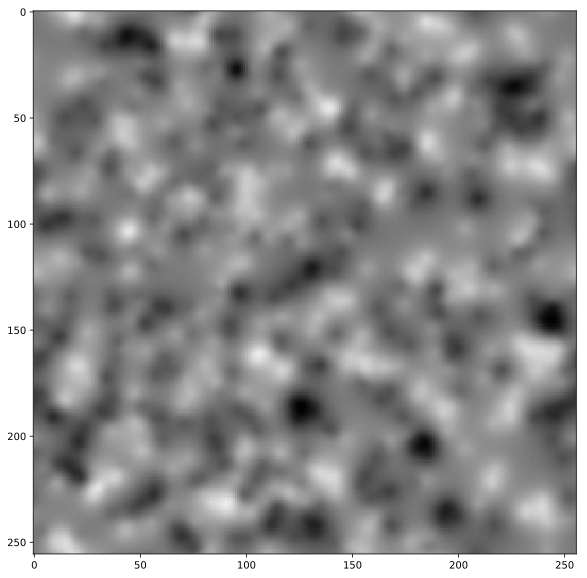

In [47]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
vmax = np.absolute(x_noise).max()
ax.imshow(x_noise, cmap=plt.gray(), vmin=-vmax, vmax=vmax);

In [48]:
x_noise = x + noise * rng.normal(size=x.shape)
events_pred = invert_r(x_noise, envelope)
print('relative L1 error=', L1_y(events, events_pred))
print('relative Squared error=', SE_y(events, events_pred))
print('relative Squared image error=', SE_x(x, envelope, events_pred))

relative L1 error= 4204.004159150151
relative Squared error= 270062.9458343889
relative Squared image error= 0.0003798510004075044


Error as a function of noise level:

In [49]:
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


In [50]:
N_scan = 15
SE = np.zeros((N_scan, 2))
noises = np.logspace(-3, -.3, N_scan, base=10)
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred = invert_r(x_noise, envelope)
    SE[i_noise, 0] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
    SE[i_noise, 1] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())

# recording for future comparisons
SE_noise = {'full': SE}

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


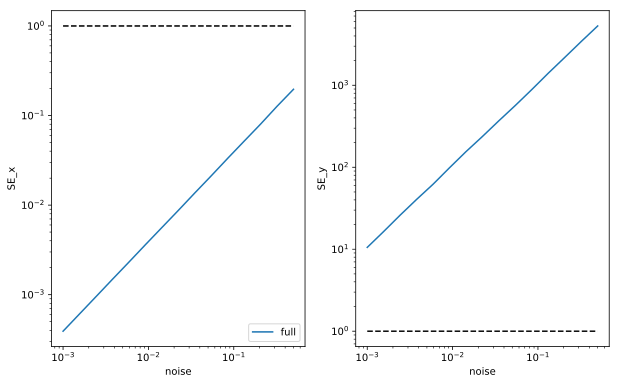

In [51]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].loglog(noises, np.ones_like(SE[:, i]), 'k--')
    ax[i].loglog(noises, SE[:, i], label='full')
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l);
ax[0].legend(loc='best');

In [52]:
x_noise = x + noise * rng.normal(size=x.shape)
events_pred = invert_r(x_noise, envelope)
print('relative L1 error=', L1_y(events, events_pred))
print('relative Squared error=', SE_y(events, events_pred))
print('relative Squared image error=', SE_x(x, envelope, events_pred))

relative L1 error= 4337.2631875769
relative Squared error= 285245.49109677813
relative Squared image error= 0.0003809074475458833


Even for this simple model, the error grows too fast wrt to noise. We need to find a solution for handling this. A first solution comes from inspecting the histogram of events' coefficients:

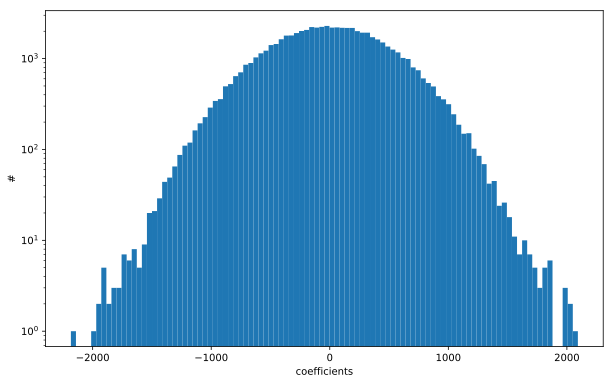

In [53]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(events_pred.ravel(), bins=100)
ax.set_xlabel('coefficients')
ax.set_yscale('log')
ax.set_ylabel('#');

Konwing the sparsity of the input, one could select only the proportion of coefficients which are big enough and remove the other ones:

In [54]:
threshold_minus = np.quantile(events_pred.ravel(), rho/2)
threshold_plus = np.quantile(events_pred.ravel(), 1.-rho/2)
print('threshold_minus=', threshold_minus, 'threshold_plus=', threshold_plus)

threshold_minus= -1263.9924656512128 threshold_plus= 1256.698466036581


In [55]:
events_pred_thr = events_pred  * ((events_pred < threshold_minus) + (events_pred > threshold_plus))
print('relative L1 error (full)=', L1_y(events, events_pred))
print('relative Squared error (full)=', SE_y(events, events_pred))
print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))

relative L1 error (full)= 4337.2631875769
relative Squared error (full)= 285245.49109677813
relative L1 error (thr)= 157.86287071341724
relative Squared error (thr)= 24107.77891287716


In [56]:
print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))
print('relative Squared image error (thr)=', SE_x(x, envelope, events_pred_thr))

relative Squared image error (full)= 0.0003809074475458833
relative Squared image error (thr)= 4925.414780917524


Doing so globally, we get

In [57]:
threshold = np.quantile(np.absolute(events_pred).ravel(), 1.-rho)
print('threshold=', threshold)

threshold= 1259.3838551292208


In [58]:
events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))
print('relative Squared image error (thr)=', SE_x(x, envelope, events_pred_thr))

relative L1 error (thr)= 157.86839990792672
relative Squared error (thr)= 24109.265610673196
relative Squared image error (thr)= 4905.191655735645


The result is worst in the image reconstruction: Indeed, the coefficients were found using the least-squared method for which the pseudo-inverse is the optimal solution. Deviating from this solution increases reconstruction error in the image domain.

Yet, it is better for the extraction of the sparse coefficients as we zero-ed out some of which we classified using our knowledge of the sparseness of the vector.

Yet, a problem is that we do not know *a priori* the sparseness. Let's see how this changes with different estimates, either by knowing the original or noisy images:

In [59]:
N_scan = 15
SE_thr = np.zeros((N_scan, 2))
SE_est = np.zeros((N_scan, 2))
rhos = np.logspace(-3, -1, N_scan, base=10)
for i_rho, rho_est in enumerate(rhos):
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    
    SE_thr[i_rho, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE_thr[i_rho, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

    SE_est[i_rho, 0] = np.sqrt(((x_noise-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE_est[i_rho, 1] = np.sqrt(((events_pred-events_pred_thr)**2).sum()/(events_pred**2).sum())
    

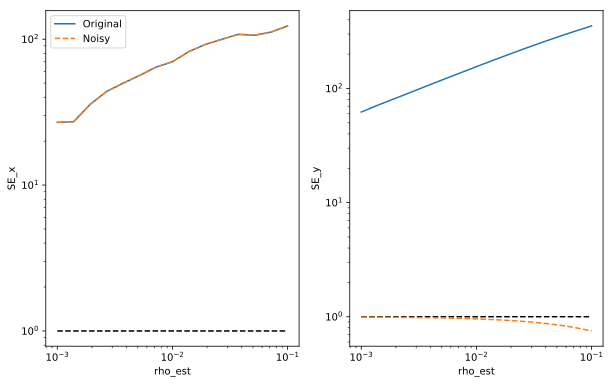

In [60]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].loglog(rhos, np.ones_like(SE_thr[:, i]), 'k--')
    ax[i].loglog(rhos, SE_thr[:, i], label='Original')
    ax[i].loglog(rhos, SE_est[:, i], '--', label='Noisy')
    ax[i].set_xlabel('rho_est')
    ax[i].set_ylabel(SE_l);
ax[0].legend(loc='best');        

Now assuming that we have an estimate of ``rho``, let's see how this method compares to the previous one ('full') for varying levels of noise:

In [61]:
rho_est = rho
SE_thr = np.zeros((N_scan, 2))
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred = invert_r(x_noise, envelope)
    
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    SE_thr[i_noise, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE_thr[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

SE_noise['thr']= SE_thr

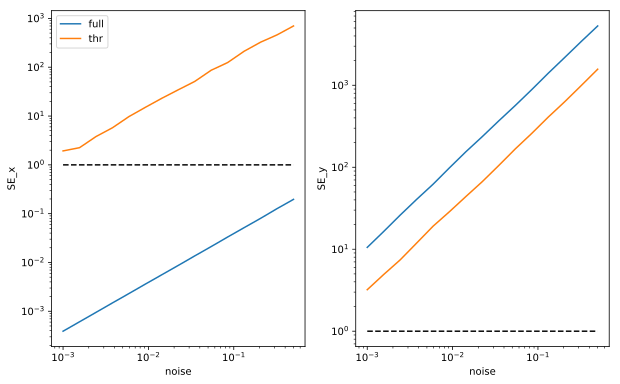

In [62]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(noises, np.ones(len(noises)), 'k--')
    for method in ['full', 'thr']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');    

Thresholding coefficients gives a better estimate of coefficients.

If we know the level of noise, one can also use Wiener filtering:

In [63]:
sigma_noise = noise
def invert_w(x, envelope, eps=1.e-16, sigma_noise=sigma_noise):
    envelope = np.fft.fftshift(envelope)[:, :(envelope.shape[1]//2+1)]
    Fx = np.fft.rfft2(x)
    F_deconv = envelope / (envelope**2 + sigma_noise**2 + eps*(envelope==0))
    # applying the filter
    F_events = Fx*F_deconv
    events = np.fft.irfft2(F_events).real 
    return events

#mc.N_X, mc.N_Y = 2**7, 2**7
envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)

events_pred = invert_w(x, envelope)
print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))
print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))


N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)
relative L1 error (thr)= 1590.8107375233124
relative Squared error (thr)= 2471429.9603055115
relative Squared image error (full)= 8.327583288838885e-06


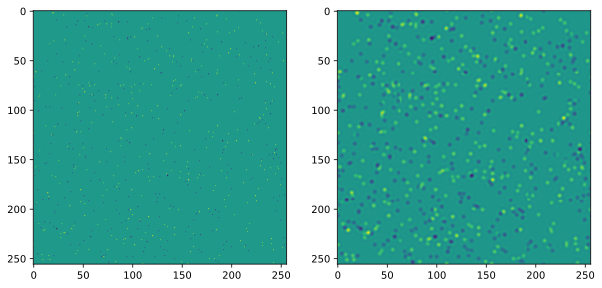

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width))
axs[0].imshow(events, cmap=plt.viridis())
axs[1].imshow(events_pred, cmap=plt.viridis());

In [65]:
rho_est = rho
SE_thr = np.zeros((N_scan, 2))
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred = invert_w(x_noise, envelope, sigma_noise=noise_)
    
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    SE_thr[i_noise, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE_thr[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

SE_noise['wie']= SE_thr

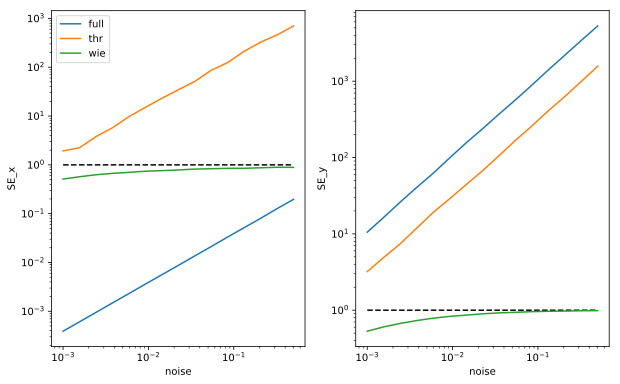

In [66]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(noises, np.ones(len(noises)), 'k--')
    for method in ['full', 'thr', 'wie']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');    

Could we repeat this procedure more times?

A first solution is to define a global cost as the LASSO problem :

$$
\mathcal{C} = .5 \cdot \| x - A y \|^2 + \lambda \| y \|_1 
$$

And to apply a gradient descent technique on this cost:


# conjugate gradient descent algorithm

setting up variables:

In [67]:
envelope = MC_env(N_X, N_Y)
events = np.zeros((N_X, N_Y))
events[N_X//2, N_Y//2] = 1
impulse = model(envelope, events)
ATA = model(envelope, impulse)
ATA_pred = model(envelope**2, events)

In [68]:
print(np.absolute(ATA_pred).max(), np.absolute(ATA).max())

7.719155888736713 7.719155888736713


In [69]:
assert(((ATA_pred-ATA)**2).sum() < 1.e-16)

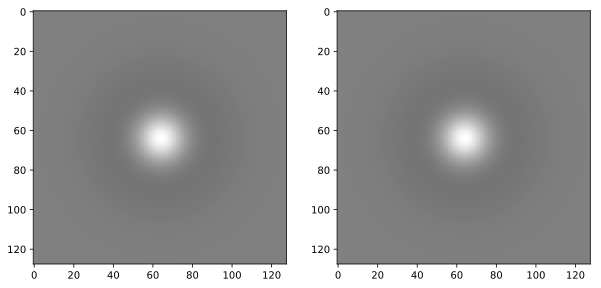

In [70]:
#fig, ax = plt.subplots(figsize=(fig_width, fig_width))
vmax = np.absolute(impulse).max()
vmax = np.absolute(ATA).max()
#ax.imshow(impulse, cmap=plt.gray(), vmin=-vmax, vmax=vmax);
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width/phi))
axs[0].imshow(ATA[(N_X//2-N_X//4):(N_X//2+N_X//4), (N_Y//2-N_Y//4):(N_Y//2+N_Y//4)], cmap=plt.gray(), vmin=-vmax, vmax=vmax); 
axs[1].imshow(ATA_pred[(N_X//2-N_X//4):(N_X//2+N_X//4), (N_Y//2-N_Y//4):(N_Y//2+N_Y//4)], cmap=plt.gray(), vmin=-vmax, vmax=vmax); 

In [71]:
print('impulse.max()', impulse.max())
print('envelope.mean()', envelope.mean())
print('ATA.max()', ATA.max())
print('(envelope**2).mean()', (envelope**2).mean())

impulse.max() 0.3470061968540875
envelope.mean() 0.34700619685408757
ATA.max() 7.719155888736713
(envelope**2).mean() 7.719155888736713


In [72]:
# envelope = MC_env(N_X, N_Y)
events, x = generative_model(envelope, verbose=True)
x_noise = x + noise * rng.normal(size=x.shape)

N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)


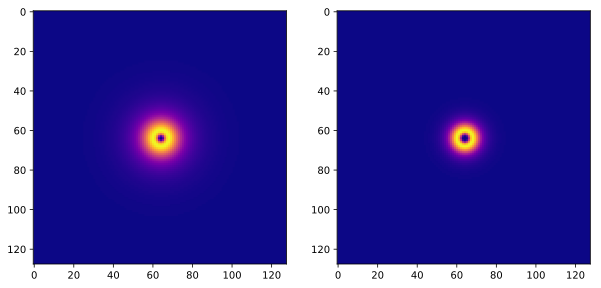

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width/phi))
axs[0].imshow(envelope[(N_X//2-N_X//4):(N_X//2+N_X//4), (N_Y//2-N_Y//4):(N_Y//2+N_Y//4)], cmap=plt.plasma()); 
axs[1].imshow(envelope[(N_X//2-N_X//4):(N_X//2+N_X//4), (N_Y//2-N_Y//4):(N_Y//2+N_Y//4)]**2, cmap=plt.plasma()); 

Let's project the image 

In [74]:
events_pred = model(envelope, x_noise, verbose=True) #/ 26.80927 # / np.sqrt(((envelope)**2).mean()) 

print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))
print('relative L1 error (full)=', L1_y(events, events_pred))
print('relative Squared error (full)=', SE_y(events, events_pred))

envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)
relative Squared image error (full)= 2816650.3598130797
relative L1 error (full)= 844.1243387906795
relative Squared error (full)= 10923.804704936989


In [75]:
threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
events_pred_thr = events_pred_thr  * ((events_pred_thr < -threshold) + (events_pred_thr > threshold))

print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))
print('relative Squared image error (thr)=', SE_x(x, envelope, events_pred_thr))

relative L1 error (thr)= 1.0
relative Squared error (thr)= 1.0
relative Squared image error (thr)= 1.0


Other stats for introspection:

In [76]:
print('Mean enveloppe energy=', (envelope**2).mean())
print('Squared enveloppe energy=', np.sqrt((envelope**2).mean()) )
print('relative Squared error=',SE_y(events, events_pred_thr))
print('energy rec=', ((events_pred)**2).sum())
print('energy input=', ((events)**2).sum())
print('ratio energy=', ((events_pred)**2).sum()/(events**2).sum())
print('Squared ratio energy=', np.sqrt((events_pred**2).sum()/(events**2).sum()))

Mean enveloppe energy= 7.719155888736713
Squared enveloppe energy= 2.7783368925918097
relative Squared error= 1.0
energy rec= 609992300.2959415
energy input= 55767.152445175845
ratio energy= 10938.20059927964
Squared ratio energy= 104.58585276833402


In [77]:
events, x = generative_model(envelope, seed=42)
x_noise = x + noise * rng.normal(size=x.shape)

In [78]:
events_pred = invert_r(x_noise, envelope)

threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))



In [79]:
error = x_noise - model(envelope, events_pred)
grad = model(envelope, error)
grad_pred = model(envelope, x_noise) - model(envelope**2, events_pred)

In [80]:
assert(((grad-grad_pred)**2).sum() < 1.e-16)


We will include information about sparsity by modifying the gradient knowing the LASSO formulation (see
https://blogs.princeton.edu/imabandit/2013/04/09/orf523-conditional-gradient-descent-and-structured-sparsity/ ) :

In [81]:
y_lambda_est = y_lambda
grad -= y_lambda_est * np.sign(events_pred)

In [82]:
N_iter = 300
eta = .05
start_iter = 10
rho_est = rho
y_lambda_est = 1. # y_lambda
sigma_noise = 2.e-3

In [83]:
N_scan = 15
default = dict(N_iter=N_iter, eta=eta, start_iter=start_iter, rho_est=rho_est, 
               y_lambda_est=y_lambda_est, sigma_noise=sigma_noise)
print('default=', default)

default= {'N_iter': 300, 'eta': 0.05, 'start_iter': 10, 'rho_est': 0.01, 'y_lambda_est': 1.0, 'sigma_noise': 0.002}


In [84]:
iters = range(N_iter)
SE_iter = np.zeros((N_iter, 2))
SE_thr = np.zeros((N_iter, 2))
# intialization
norm_enveloppe = 1# np.sqrt((envelope**2).mean())
#events_pred = 0. * model(envelope, x_noise) / norm_enveloppe
events_pred = invert_w(x_noise, envelope, sigma_noise=noise)

threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
events_pred = events_pred_thr #np.zeros_like(x_noise)

# iterations
for i_iter in iters:
    # predicting
    grad = model(envelope, x_noise) - model(envelope**2, events_pred)
    grad -= y_lambda_est * np.sign(events_pred)
    events_pred += eta / (i_iter+start_iter) * grad

    # thresholding
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1.-rho_est)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

    # measuring efficiency
    #SE_iter[i_iter, 0] = np.sqrt((error**2).sum()/(x**2).sum())
    SE_iter[i_iter, 0] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
    SE_iter[i_iter, 1] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())

    SE_thr[i_iter, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE_thr[i_iter, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

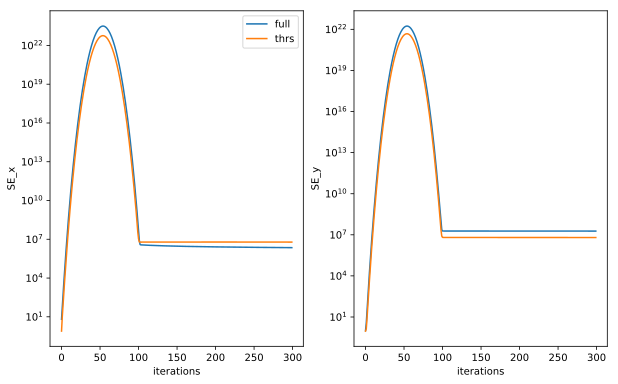

In [85]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(iters, SE_iter[:, i], label='full')
    ax[i].plot(iters, SE_thr[:, i], label='thrs')
    ax[i].set_xlabel('iterations')
    ax[i].set_ylabel(SE_l)
    #ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');        

Let's now test this function over its different parameters:

In [86]:
events, x = generative_model(envelope, seed=42)
x_noise = x + noise * rng.normal(size=x.shape)


def cg(x_noise, envelope, 
       N_iter=N_iter, eta=eta, start_iter=start_iter, rho_est=rho_est, 
       y_lambda_est=y_lambda_est, sigma_noise=sigma_noise):  
    
    #events_pred = np.zeros_like(x_noise)
    events_pred = invert_w(x_noise, envelope, sigma_noise=sigma_noise)
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
    events_pred *= ((events_pred < -threshold) + (events_pred > threshold))

    iters = range(int(N_iter))

    # iterations
    for i_iter in iters:
        # predicting
        grad = model(envelope, x_noise) - model(envelope**2, events_pred)
        grad -= y_lambda_est * np.sign(events_pred)
        events_pred += eta/(i_iter+int(start_iter)) * grad
    
    return events_pred

Testing with and without the sparsity:

In [87]:
events_pred = cg(x_noise, envelope, y_lambda_est=y_lambda_est)
print('relative L1 error (full)=', L1_y(events, events_pred))
print('relative Squared error (full)=', SE_y(events, events_pred))
print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))
threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))
print('relative Squared image error (thr)=', SE_x(x, envelope, events_pred_thr))


relative L1 error (full)= 327019984.8037032
relative Squared error (full)= 1735302203633952.8
relative Squared image error (full)= 19971534961361.734
relative L1 error (thr)= 14165214.69285995
relative Squared error (thr)= 198278118137569.88
relative Squared image error (thr)= 198706231767676.72


In [88]:
events_pred = cg(x_noise, envelope, y_lambda_est=0)
print('relative L1 error (full)=', L1_y(events, events_pred))
print('relative Squared error (full)=', SE_y(events, events_pred))
print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))
threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

print('relative L1 error (thr)=', L1_y(events, events_pred_thr))
print('relative Squared error (thr)=', SE_y(events, events_pred_thr))
print('relative Squared image error (thr)=', SE_x(x, envelope, events_pred_thr))


relative L1 error (full)= 316395889.39540094
relative Squared error (full)= 1634405727454801.0
relative Squared image error (full)= 25566455920209.08
relative L1 error (thr)= 13823734.585262422
relative Squared error (thr)= 188582297875920.8
relative Squared image error (thr)= 138455565903917.47


In [89]:
SE = {}
SE_thr = {}
for variable in default.keys():    
    SE[variable] = np.zeros((N_scan, 2))
    SE_thr[variable] = np.zeros((N_scan, 2))
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    for i_value, value in enumerate(values):
        opts = default.copy()
        opts[variable] = value
        print('variable', variable, '=', '%.3f' % opts[variable], ' - default=', '%.3f' % default[variable])
        x_noise = x + noise * rng.normal(size=x.shape)
        events_pred = cg(x_noise, envelope, **opts)

        SE[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
        SE[variable][i_value, 1] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())
    
        threshold = np.quantile(np.absolute(events_pred).ravel(), 1-opts['rho_est'])
        events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

        SE_thr[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
        SE_thr[variable][i_value, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

variable N_iter = 30.000  - default= 300.000
variable N_iter = 41.685  - default= 300.000
variable N_iter = 57.921  - default= 300.000
variable N_iter = 80.481  - default= 300.000
variable N_iter = 111.828  - default= 300.000
variable N_iter = 155.384  - default= 300.000
variable N_iter = 215.906  - default= 300.000
variable N_iter = 300.000  - default= 300.000
variable N_iter = 416.849  - default= 300.000
variable N_iter = 579.209  - default= 300.000
variable N_iter = 804.809  - default= 300.000
variable N_iter = 1118.278  - default= 300.000
variable N_iter = 1553.842  - default= 300.000
variable N_iter = 2159.057  - default= 300.000
variable N_iter = 3000.000  - default= 300.000
variable eta = 0.005  - default= 0.050
variable eta = 0.007  - default= 0.050
variable eta = 0.010  - default= 0.050
variable eta = 0.013  - default= 0.050
variable eta = 0.019  - default= 0.050
variable eta = 0.026  - default= 0.050
variable eta = 0.036  - default= 0.050
variable eta = 0.050  - default= 0.05

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


variable eta = 0.360  - default= 0.050
variable eta = 0.500  - default= 0.050
variable start_iter = 1.000  - default= 10.000
variable start_iter = 1.389  - default= 10.000
variable start_iter = 1.931  - default= 10.000
variable start_iter = 2.683  - default= 10.000
variable start_iter = 3.728  - default= 10.000
variable start_iter = 5.179  - default= 10.000
variable start_iter = 7.197  - default= 10.000
variable start_iter = 10.000  - default= 10.000
variable start_iter = 13.895  - default= 10.000
variable start_iter = 19.307  - default= 10.000
variable start_iter = 26.827  - default= 10.000
variable start_iter = 37.276  - default= 10.000
variable start_iter = 51.795  - default= 10.000
variable start_iter = 71.969  - default= 10.000
variable start_iter = 100.000  - default= 10.000
variable rho_est = 0.001  - default= 0.010
variable rho_est = 0.001  - default= 0.010
variable rho_est = 0.002  - default= 0.010
variable rho_est = 0.003  - default= 0.010
variable rho_est = 0.004  - default=

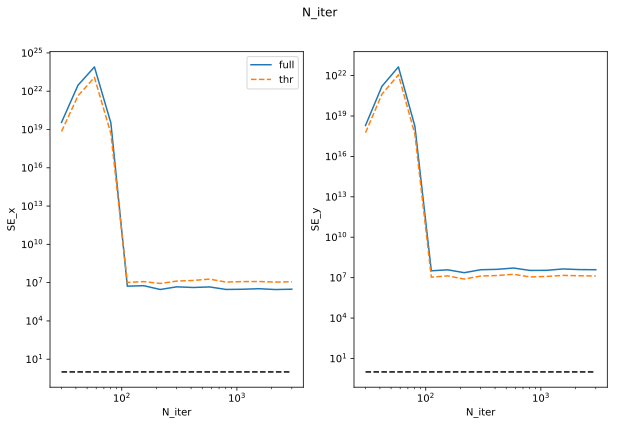

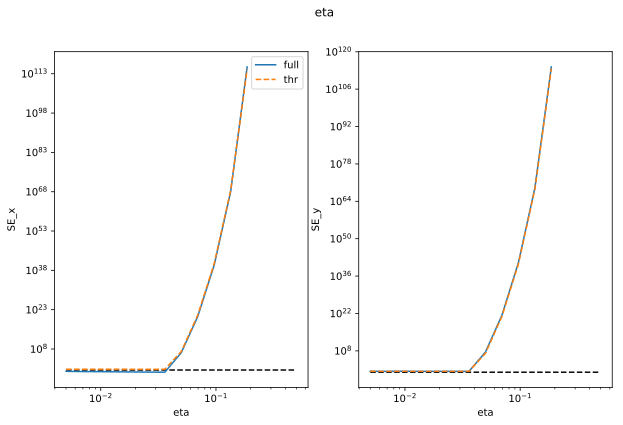

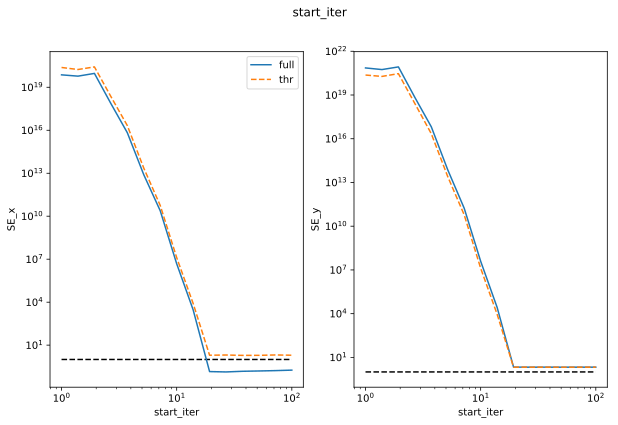

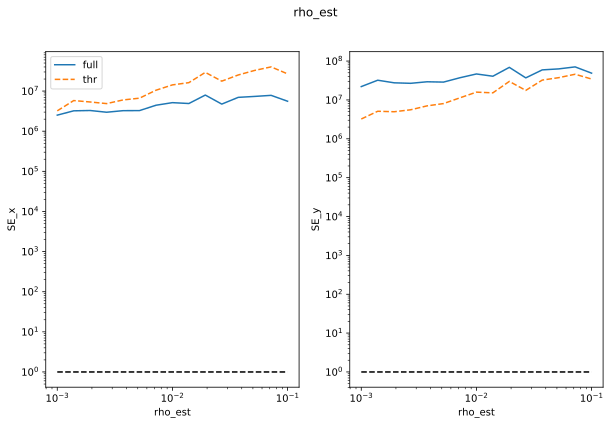

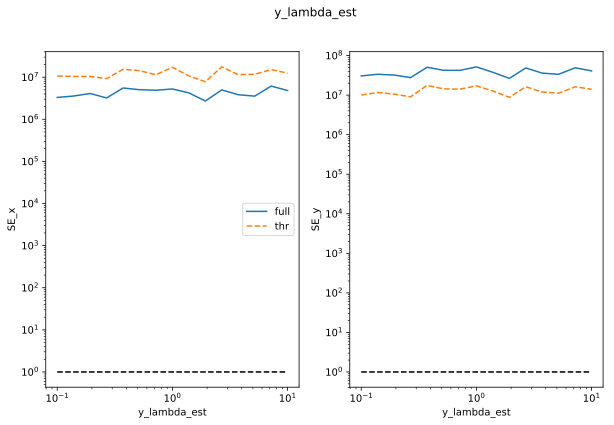

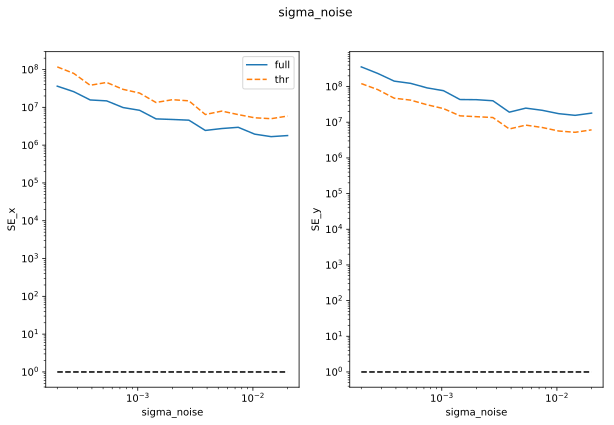

In [90]:
for variable in default.keys():    
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, SE_l in enumerate(['SE_x', 'SE_y']):
        ax[i].plot(values, np.ones_like(SE_thr[variable][:, i]), 'k--')
        ax[i].plot(values, SE[variable][:, i], label='full')
        ax[i].plot(values, SE_thr[variable][:, i], '--', label='thr')
        ax[i].set_xlabel(variable)
        ax[i].set_ylabel(SE_l);
        fig.suptitle(variable)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
    ax[0].legend(loc='best');        

And now for different levels of noise:

In [91]:
rho_est = rho
SE = np.zeros((N_scan, 2))
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred = cg(x_noise, envelope, sigma_noise=noise_)
    
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    
    SE[i_noise, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
    SE[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

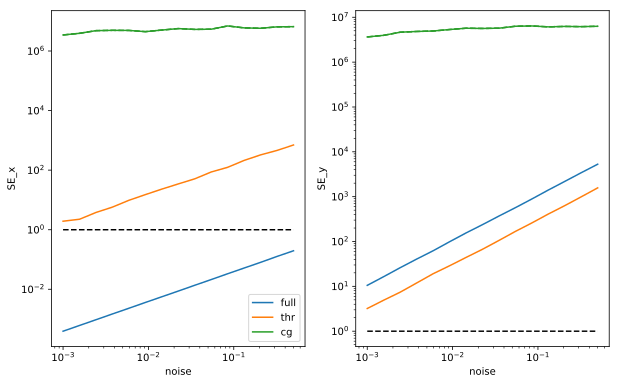

In [92]:
SE_noise['cg'] = SE

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(noises, np.ones(len(noises)), 'k--')
    ax[i].plot(noises, SE[:, i], 'g--')
    for method in ['full', 'thr', 'cg']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');    


It converges to a better solution as the simple thresholding, but yet the convergence is slow. Another solution is deployed in iterative thresholding.

Some nice pointers:
 * [the FISTA paper](http://people.rennes.inria.fr/Cedric.Herzet/Cedric.Herzet/Sparse_Seminar/Entrees/2012/11/12_A_Fast_Iterative_Shrinkage-Thresholding_Algorithmfor_Linear_Inverse_Problems_(A._Beck,_M._Teboulle)_files/Breck_2009.pdf) 
 * lectures on FISTA http://stat.cmu.edu/~ryantibs/convexopt/lectures/prox-grad.pdf http://www.seas.ucla.edu/~vandenbe/236C/lectures/fista.pdf 
 * https://blogs.princeton.edu/imabandit/2013/04/11/orf523-ista-and-fista/
 

# ISTA: iterative shrinkage-thresholding algorithm

An implementation in matlab: https://github.com/seunghwanyoo/ista_lasso - an one in python on a toy problem: https://gist.github.com/agramfort/ac52a57dc6551138e89b 

As we have seen we can invert events from a noisy image, but the error is big...

In [93]:
env = MC_env(N_X, N_Y)
events, x = generative_model(env, verbose=True)

x_noise = x + noise * rng.normal(size=x.shape)
events_pred = invert_r(x_noise, envelope)
print('relative Squared image error (full)=', SE_x(x, envelope, events_pred))
print('relative L1 error (full)=', L1_y(events, events_pred))
print('relative Squared error (full)=', SE_y(events, events_pred))


N_X, N_Y =  (256, 256)
envelope.shape =  (256, 256)
events.shape =  (256, 256)
x.shape= (256, 256)
relative Squared image error (full)= 0.0003807430849629458
relative L1 error (full)= 4363.019216775068
relative Squared error (full)= 292595.3199405096


One idea is to the same procedure iteratively, as we know that the events matrix is sparse:

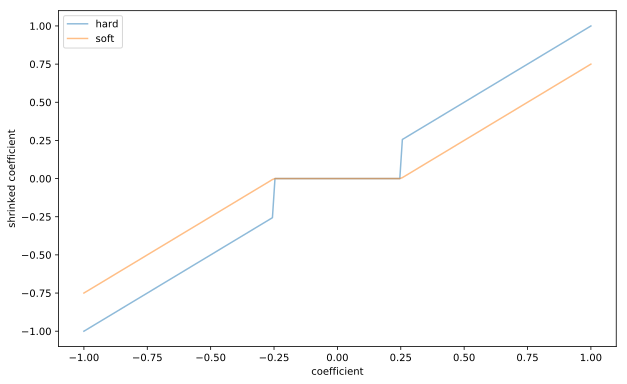

In [94]:
def shrinkage(events_pred, threshold, stype='soft'):
    if stype=='hard':
        events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    else:
        events_pred_thr = np.sign(events_pred) * np.maximum(np.abs(events_pred)-threshold, 0.)
    return events_pred_thr

fig, ax = plt.subplots(figsize=figsize)
events_pred = np.linspace(-1, 1, 200, endpoint=True)
for stype in ['hard', 'soft']:
    ax.plot(events_pred, shrinkage(events_pred, threshold=.25, stype=stype), label=stype, alpha=.5)

ax.legend(loc='best')
ax.set_xlabel('coefficient')
ax.set_ylabel('shrinked coefficient');

In [95]:
N_iter = 300
eta = .005
y_lambda_est = 1.
sigma_noise = 3.e-3
rho_est = 1.e-2
start_iter = 2

L = 1 / eta # Lipschitz constant

In [96]:
N_scan = 15
default = dict(N_iter=N_iter, sigma_noise=sigma_noise, rho_est=rho_est, y_lambda_est=y_lambda_est, eta=eta, start_iter=start_iter)
print('default=', default)

default= {'N_iter': 300, 'sigma_noise': 0.003, 'rho_est': 0.01, 'y_lambda_est': 1.0, 'eta': 0.005, 'start_iter': 2}


In [97]:
iters = range(N_iter)
SE_iter = np.zeros((N_iter, 2, 2))
SE_thr = np.zeros((N_iter, 2, 2))
for i_type, stype in enumerate(['soft', 'hard']):
    if True:
        # intialization - with the denoising solution:
        events_pred = invert_w(x_noise, envelope, sigma_noise=sigma_noise)
        # thresholding
        threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
        events_pred = shrinkage(events_pred, threshold=threshold, stype='hard')    
    else:
        events_pred = np.zeros_like(x_noise)

    AT_x_noise = model(envelope, x_noise)
    envelope2 = envelope**2
    # iterations
    for i_iter in iters:
        # predicting
        grad = AT_x_noise - model(envelope**2, events_pred)
        #grad = model(envelope, x_noise - model(envelope, events_pred))
        #grad -= y_lambda_est * np.sign(events_pred)
        
        eta_ = eta / np.sqrt(i_iter+start_iter)
        events_pred += eta_ * grad
        
        # shrinkage operator
        events_pred = shrinkage(events_pred, threshold=eta_*y_lambda_est, stype=stype)    
        
        # measuring efficiency
        SE_iter[i_iter, 0, i_type] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
        SE_iter[i_iter, 1, i_type] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())
        
        # thresholding
        threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_est)
        events_pred_thr = shrinkage(events_pred, threshold=threshold, stype='hard')    

        SE_thr[i_iter, 0, i_type] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
        SE_thr[i_iter, 1, i_type] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

        

In [98]:
SE_iter[-1, ...]

array([[0.098679, 0.084891],
       [1.514745, 1.526471]])

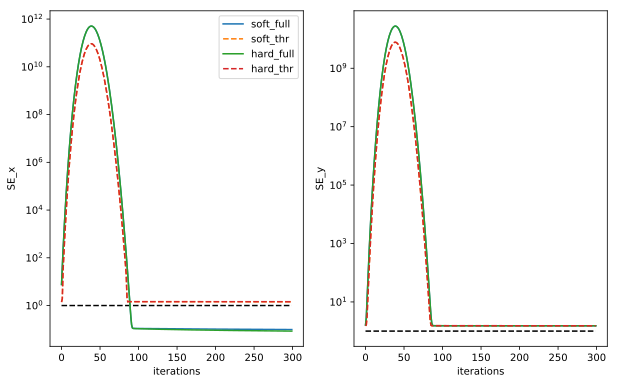

In [99]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(iters,np.ones_like(SE_iter[:, i, 0]), 'k--')
    for i_type, stype in enumerate(['soft', 'hard']):
        ax[i].plot(iters, SE_iter[:, i, i_type], label=stype + '_full')
        ax[i].plot(iters, SE_thr[:, i, i_type], '--', label=stype + '_thr')
        ax[i].set_xlabel('iterations')
        ax[i].set_ylabel(SE_l)
    #ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');        

Now testing ISTA to explore the effect of parameters:

In [100]:
def ISTA(x_noise, envelope, eta=eta, start_iter=start_iter, y_lambda_est=y_lambda_est, rho_est=rho_est, sigma_noise=sigma_noise, N_iter=N_iter, stype='soft'):
    # intialization
    events_pred = invert_w(x_noise, envelope, sigma_noise=sigma_noise)
    AT_x_noise = model(envelope, x_noise)
    envelope2 = envelope**2
    
    # iterations
    iters = range(int(N_iter))
    for i_iter in iters:
        # predicting
        grad = AT_x_noise - model(envelope2, events_pred)
        
        eta_ = eta / np.sqrt(i_iter+start_iter)
        events_pred += eta_ * grad

        # thresholding
        events_pred = shrinkage(events_pred, threshold=eta_*y_lambda_est, stype=stype)            
        
    return events_pred

Testing different parameters:

In [101]:
SE = {}
SE_thr = {}
for variable in default.keys():    
    SE[variable] = np.zeros((N_scan, 2))
    SE_thr[variable] = np.zeros((N_scan, 2))
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    for i_value, value in enumerate(values):
        opts = default.copy()
        opts[variable] = value
        print('variable', variable, '=', '%.3f' % opts[variable], ' - default=', '%.3f' % default[variable])
        x_noise = x + noise * rng.normal(size=x.shape)
        events_pred = ISTA(x_noise, envelope, **opts)

        SE[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
        SE[variable][i_value, 1] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())
    
        threshold = np.quantile(np.absolute(events_pred).ravel(), 1-opts['rho_est'])
        events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

        SE_thr[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
        SE_thr[variable][i_value, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

variable N_iter = 30.000  - default= 300.000
variable N_iter = 41.685  - default= 300.000
variable N_iter = 57.921  - default= 300.000
variable N_iter = 80.481  - default= 300.000
variable N_iter = 111.828  - default= 300.000
variable N_iter = 155.384  - default= 300.000
variable N_iter = 215.906  - default= 300.000
variable N_iter = 300.000  - default= 300.000
variable N_iter = 416.849  - default= 300.000
variable N_iter = 579.209  - default= 300.000
variable N_iter = 804.809  - default= 300.000
variable N_iter = 1118.278  - default= 300.000
variable N_iter = 1553.842  - default= 300.000
variable N_iter = 2159.057  - default= 300.000
variable N_iter = 3000.000  - default= 300.000
variable sigma_noise = 0.000  - default= 0.003
variable sigma_noise = 0.000  - default= 0.003
variable sigma_noise = 0.001  - default= 0.003
variable sigma_noise = 0.001  - default= 0.003
variable sigma_noise = 0.001  - default= 0.003
variable sigma_noise = 0.002  - default= 0.003
variable sigma_noise = 0.002

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


variable eta = 0.026  - default= 0.005
variable eta = 0.036  - default= 0.005
variable eta = 0.050  - default= 0.005


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/usr/local/lib/python3.7/site-packages/numpy/fft/fftpack.py:288: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in maximum
  """
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


variable start_iter = 0.200  - default= 2.000
variable start_iter = 0.278  - default= 2.000
variable start_iter = 0.386  - default= 2.000
variable start_iter = 0.537  - default= 2.000
variable start_iter = 0.746  - default= 2.000
variable start_iter = 1.036  - default= 2.000
variable start_iter = 1.439  - default= 2.000
variable start_iter = 2.000  - default= 2.000
variable start_iter = 2.779  - default= 2.000
variable start_iter = 3.861  - default= 2.000
variable start_iter = 5.365  - default= 2.000
variable start_iter = 7.455  - default= 2.000
variable start_iter = 10.359  - default= 2.000
variable start_iter = 14.394  - default= 2.000
variable start_iter = 20.000  - default= 2.000


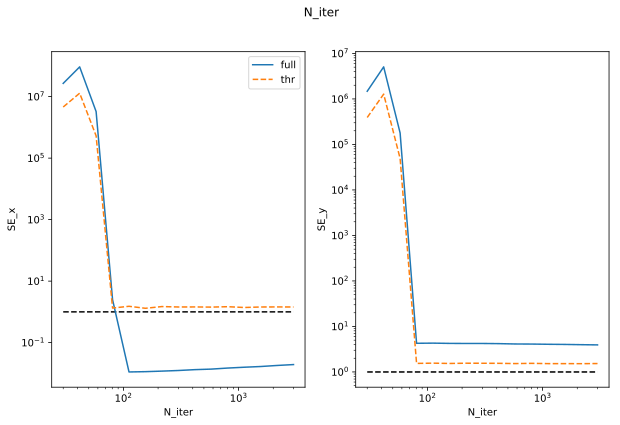

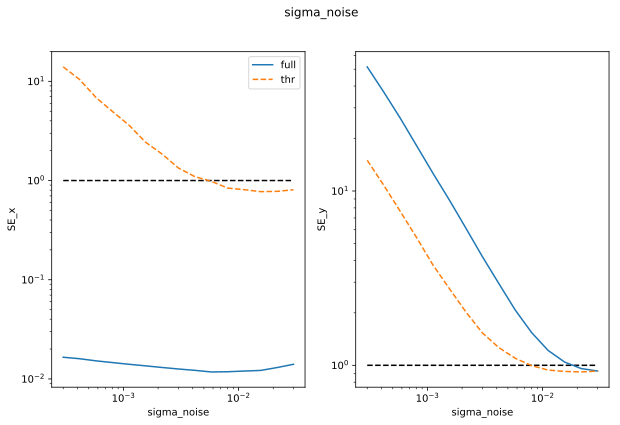

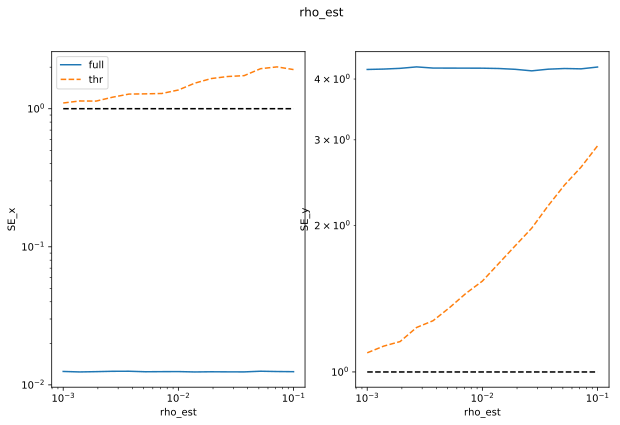

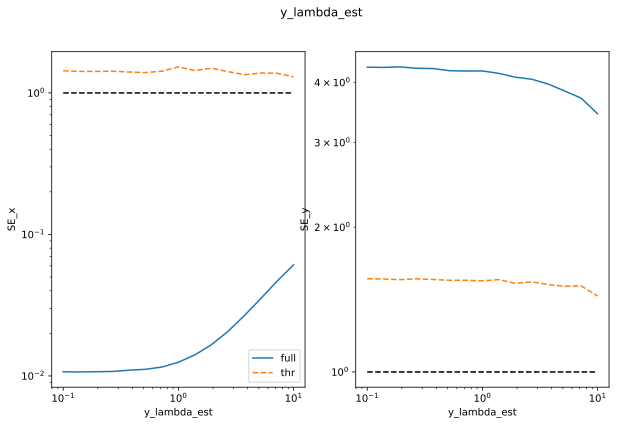

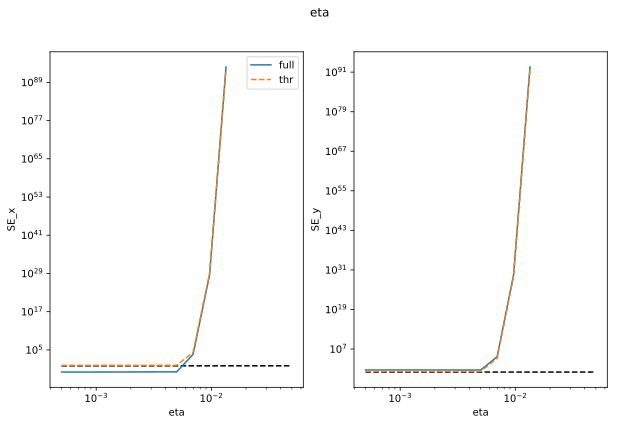

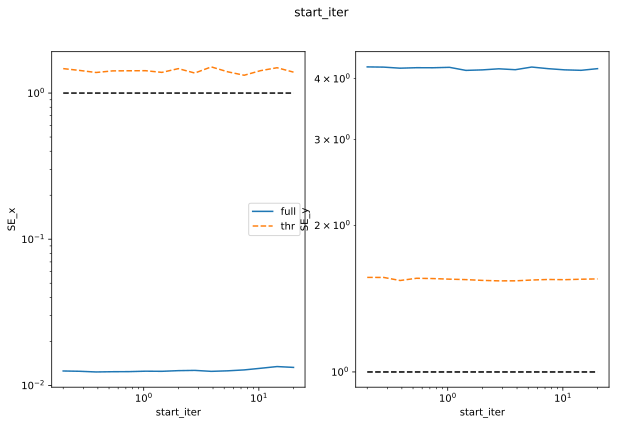

In [102]:
for variable in default.keys():
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, SE_l in enumerate(['SE_x', 'SE_y']):
        ax[i].plot(values, np.ones_like(SE_thr[variable][:, i]), 'k--')
        ax[i].plot(values, SE[variable][:, i], label='full')
        ax[i].plot(values, SE_thr[variable][:, i], '--', label='thr')
        ax[i].set_xlabel(variable)
        ax[i].set_ylabel(SE_l);
        fig.suptitle(variable)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
    ax[0].legend(loc='best');        

In [103]:
SE_ista = np.zeros((N_scan, 2))
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred_thr = ISTA(x_noise, envelope)
    SE_ista[i_noise, 0] = ((x-model(env, events_pred_thr[:, :, None]))**2).sum()/((x.squeeze())**2).sum()
    SE_ista[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())


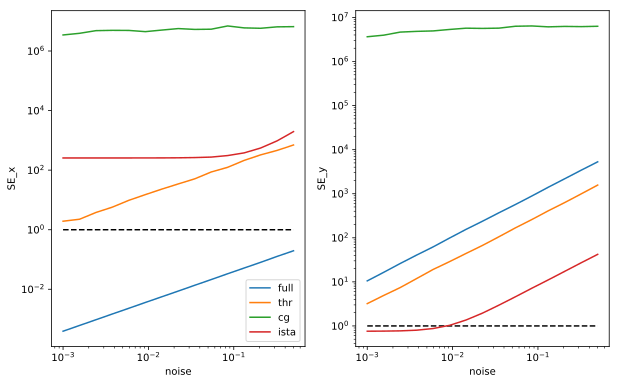

In [104]:
SE_noise['ista']= SE_ista

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(noises, np.ones(len(noises)), 'k--')
    for method in ['full', 'thr', 'cg', 'ista']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');    

## FISTA: Fast ISTA



In [105]:
def FISTA(x_noise, envelope, rho_est=rho_est, sigma_noise=sigma_noise, N_iter=N_iter, stype='soft'):
    # intialization
    events_pred = events_pred_thr = events_pred_thr_ = invert_w(x_noise, envelope, sigma_noise=sigma_noise)
    t = 1
    # iterations
    iters = range(int(N_iter))
    for i_iter in iters:
        t_old = t
        t = .5 * (1 + np.sqrt(1 + 4*t**2))
        
        events_old = events_pred
        events_pred_thr_old = events_pred_thr_
        
        grad = model(envelope, x_noise) - model(envelope**2, events_pred_thr)
        #grad -= y_lambda_est * np.sign(events_pred_thr)
        events_pred += eta / (i_iter+1) * grad
        
    return events_pred

In [106]:
N_scan = 15
default = dict(N_iter=100, rho_est=1.e-2, sigma_noise=1.e-3)
print('default=', default)

default= {'N_iter': 100, 'rho_est': 0.01, 'sigma_noise': 0.001}


In [107]:
SE = {}
SE_thr = {}
for variable in default.keys():    
    SE[variable] = np.zeros((N_scan, 2))
    SE_thr[variable] = np.zeros((N_scan, 2))
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    for i_value, value in enumerate(values):
        opts = default.copy()
        opts[variable] = value
        print('variable', variable, '=', '%.3f' % opts[variable], ' - default=', '%.3f' % default[variable])
        x_noise = x + noise * rng.normal(size=x.shape)
        events_pred = FISTA(x_noise, envelope, **opts)

        SE[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred))**2).sum()/(x**2).sum())
        SE[variable][i_value, 1] = np.sqrt(((events-events_pred)**2).sum()/(events**2).sum())
    
        threshold = np.quantile(np.absolute(events_pred).ravel(), 1-opts['rho_est'])
        events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))

        SE_thr[variable][i_value, 0] = np.sqrt(((x-model(envelope, events_pred_thr))**2).sum()/(x**2).sum())
        SE_thr[variable][i_value, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())

variable N_iter = 10.000  - default= 100.000
variable N_iter = 13.895  - default= 100.000
variable N_iter = 19.307  - default= 100.000
variable N_iter = 26.827  - default= 100.000
variable N_iter = 37.276  - default= 100.000
variable N_iter = 51.795  - default= 100.000
variable N_iter = 71.969  - default= 100.000
variable N_iter = 100.000  - default= 100.000
variable N_iter = 138.950  - default= 100.000
variable N_iter = 193.070  - default= 100.000
variable N_iter = 268.270  - default= 100.000
variable N_iter = 372.759  - default= 100.000
variable N_iter = 517.947  - default= 100.000
variable N_iter = 719.686  - default= 100.000
variable N_iter = 1000.000  - default= 100.000
variable rho_est = 0.001  - default= 0.010
variable rho_est = 0.001  - default= 0.010
variable rho_est = 0.002  - default= 0.010
variable rho_est = 0.003  - default= 0.010
variable rho_est = 0.004  - default= 0.010
variable rho_est = 0.005  - default= 0.010
variable rho_est = 0.007  - default= 0.010
variable rho_es

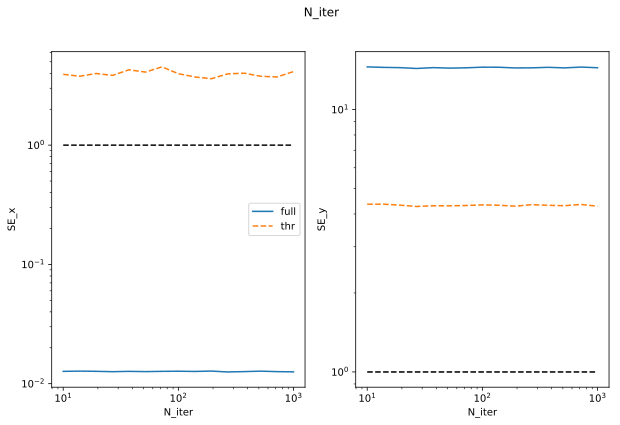

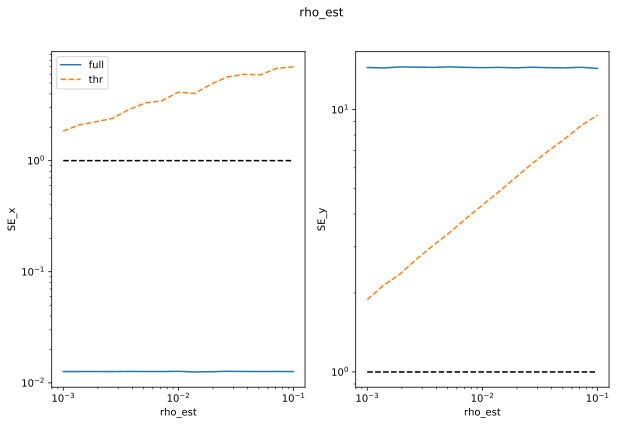

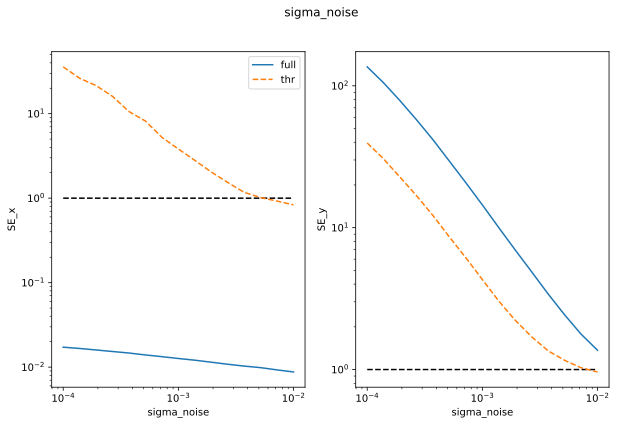

In [108]:
for variable in default.keys():
    values = np.logspace(-1, 1, N_scan, base=10) * default[variable]
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for i, SE_l in enumerate(['SE_x', 'SE_y']):
        ax[i].plot(values, np.ones_like(SE_thr[variable][:, i]), 'k--')
        ax[i].plot(values, SE[variable][:, i], label='full')
        ax[i].plot(values, SE_thr[variable][:, i], '--', label='thr')
        ax[i].set_xlabel(variable)
        ax[i].set_ylabel(SE_l);
        fig.suptitle(variable)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
    ax[0].legend(loc='best');        

In [109]:
SE_fista = np.zeros((N_scan, 2))
for i_noise, noise_ in enumerate(noises):
    x_noise = x + noise_ * rng.normal(size=x.shape)
    events_pred_thr = FISTA(x_noise, envelope, sigma_noise=noise_)
    SE_fista[i_noise, 0] = ((x-model(env, events_pred_thr[:, :, None]))**2).sum()/((x.squeeze())**2).sum()
    SE_fista[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())
SE_noise['fista']= SE_fista

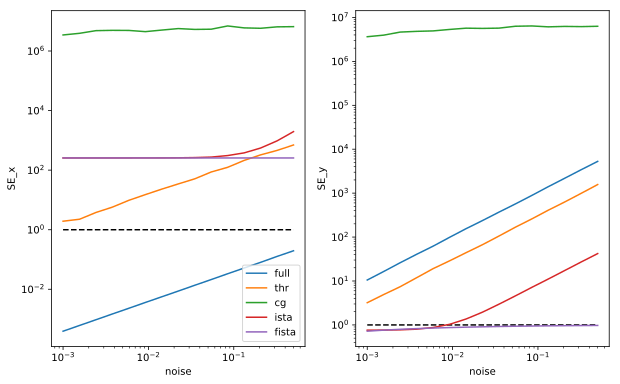

In [110]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].loglog(noises, np.ones_like(SE_noise[method][:, i]), 'k--')
    for method in ['full', 'thr', 'cg', 'ista', 'fista']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
ax[0].legend(loc='best');

Checking the efficiency for different sparseness levels

In [111]:
#N_X, N_Y = 2**10, 2**10
#N_X, N_Y = 2**7, 2**7
#noise = .04
envelope = MC_env(N_X, N_Y)

SE_thr = np.zeros((N_scan, 2))
SE_ista = np.zeros((N_scan, 2))
SE_fista = np.zeros((N_scan, 2))
rhos = np.logspace(-4, -2, N_scan, base=10)
for i_rho, rho_ in enumerate(rhos):
    events, x = generative_model(envelope, rho=rho_)

    x_noise = x + noise * rng.normal(size=x.shape)

    events_pred = invert_r(x_noise, envelope)
    threshold = np.quantile(np.absolute(events_pred).ravel(), 1-rho_)
    events_pred_thr = events_pred  * ((events_pred < -threshold) + (events_pred > threshold))
    
    SE_thr[i_noise, 0] = np.sqrt(((x-model(env, events_pred_thr[:, :, None]))**2).sum()/((x.squeeze())**2).sum())
    SE_thr[i_noise, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())
    
    events_pred_thr = ISTA(x_noise, envelope, rho_est=rho_)

    SE_ista[i_rho, 0] =np.sqrt(((x-model(env, events_pred_thr[:, :, None]))**2).sum()/((x.squeeze())**2).sum())
    SE_ista[i_rho, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())


    events_pred_thr = FISTA(x_noise, envelope, rho_est=rho_)

    SE_fista[i_rho, 0] = np.sqrt(((x-model(env, events_pred_thr[:, :, None]))**2).sum()/((x.squeeze())**2).sum())
    SE_fista[i_rho, 1] = np.sqrt(((events-events_pred_thr)**2).sum()/(events**2).sum())




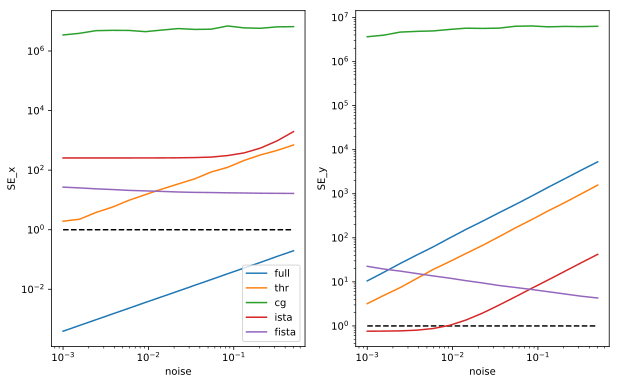

In [112]:
SE_noise['fista']= SE_fista

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, SE_l in enumerate(['SE_x', 'SE_y']):
    ax[i].plot(noises, np.ones(len(noises)), 'k--')
    for method in ['full', 'thr', 'cg', 'ista', 'fista']:
        ax[i].plot(noises, SE_noise[method][:, i], label=method)
    ax[i].set_xlabel('noise')
    ax[i].set_ylabel(SE_l)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].legend(loc='best');    

 * TODO: learn enveloppe http://yann.lecun.com/exdb/publis/pdf/gregor-icml-10.pdf
 * TODO: Noisy case: correlated noise



## some book keeping for the notebook

In [113]:
%load_ext watermark
%watermark

2019-01-06T10:12:27+01:00

CPython 3.7.2
IPython 7.2.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [114]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy, pillow, imageio

Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.15.4
scipy 1.2.0
matplotlib 3.0.2
sympy 1.3
pillow 5.4.0
imageio 2.4.1
Sun Jan 06 10:12:28 2019 CET